In [1]:
import pandas as pd
from datetime import datetime
import time
from p_drought_indices.analysis.visualizations.viz_vci_spi import get_subplot_year, adjust_full_list, str_month

import xarray as xr
from p_drought_indices.functions.function_clns import load_config, prepare, subsetting_pipeline
import os
from p_drought_indices.functions.function_clns import crop_get_spi, crop_get_thresh
from p_drought_indices.analysis.visualizations.viz_vci_spi import box_plot_year, get_xarray_time_subset, multiple_spi_boxplots, get_subplot_year, subsetting_whole
import numpy as np
import warnings
from matplotlib import gridspec
import matplotlib.patches as mpatches
from matplotlib import gridspec
import calendar
import matplotlib.pyplot as plt
from p_drought_indices.analysis.visualizations.viz_vci_spi import plot_precp_2009_event,plot_veg_2009_event, plot_spi_2009_event
from p_drought_indices.ancillary_vars.esa_landuse import get_level_colors, get_cover_dataset


warnings.filterwarnings('ignore')


CONFIG_PATH = "../config.yaml"
config = load_config(CONFIG_PATH)
ds_ndvi = xr.open_dataset(os.path.join(config['NDVI']['ndvi_path'], 'smoothed_ndvi_1.nc'))
vci = xr.open_dataset(os.path.join(config['NDVI']['ndvi_path'], 'vci_1D.nc'))
res_ds = xr.open_dataset(os.path.join(config['NDVI']['ndvi_path'], 'percentage_ndvi.nc'))

config_directories = [config['SPI']['IMERG']['path'], config['SPI']['GPCC']['path'], config['SPI']['CHIRPS']['path'], config['SPI']['ERA5']['path'], config['SPI']['MSWEP']['path'] ]
config_dir_precp = [config['PRECIP']['IMERG']['path'],config['PRECIP']['GPCC']['path'], config['PRECIP']['CHIRPS']['path'], config['PRECIP']['ERA5']['path'],  config['PRECIP']['TAMSTAT']['path'],config['PRECIP']['MSWEP']['path']]
            
#config['PRECIP']['CHIRPS_05']['path'], 

prod = "ERA5"
late = 90
product_dir = [f for f in config_dir_precp if prod in f][0]
list_files = [f for f in os.listdir(product_dir) if (f.endswith(".nc")) and ("merged" in f)]
precp_ds = xr.open_dataset(os.path.join(product_dir, list_files[0]))
variable = [var for var in precp_ds.data_vars if var!= "spatial_ref"][0]

spi_dir = [f for f in config_directories if prod in f][0]
var_target = f"spi_gamma_{late}"
files = [f for f in os.listdir(spi_dir) if var_target in f ]
spi_ds = xr.open_dataset(os.path.join(spi_dir, files[0]))

In [2]:
path = "/media/BIFROST/N2/Riccardo/CHIRPS/daily/CHIRPS/CHIRPS_25"

file = [os.path.join(path, f) for f in os.listdir(path) if f.endswith(".nc")][:-1]
ds_new = xr.open_mfdataset(file)
#ds_new = subsetting_pipeline(CONFIG_PATH, ds_new)

In [60]:
final_df = pd.DataFrame()

from typing import Union, Literal

def extract_climatology(file:Union[str,None]=None, prod:Union[str,None]="ERA5", funct:Literal["median","mean"]="median")->pd.Series:

    if prod ==None and file !=None:
        prod = file.split("/")[5]

    product_dir = [f for f in config_dir_precp if prod in f][0]
    list_files = [f for f in os.listdir(product_dir) if (f.endswith(".nc")) and ("merged" in f)]
    precp_ds = xr.open_dataset(os.path.join(product_dir, list_files[0]))
    variable = [var for var in precp_ds.data_vars if var!= "spatial_ref"][0]
    if funct=="median":
        dataset_precp = pd.Series(precp_ds[variable].median(["lat","lon"]).groupby("time.dayofyear").median().values)
    if funct=="mean":
        dataset_precp = pd.Series(precp_ds[variable].mean(["lat","lon"]).groupby("time.dayofyear").mean().values)

    return dataset_precp

#for file in config_dir_precp:
#final_df[prod] = dataset_precp

dataset_precp = extract_climatology(prod="CHIRPS")

In [76]:
dataset = dataset_precp["precip"].sel(lat=-1, lon= 36, method="nearest").values

In [ ]:
prod = "CHIRPS"
variable = [var for var in ds_new.data_vars if var!= "spatial_ref"][0]
dataset_precp = pd.Series(ds_new[variable].median(["lat","lon"]).groupby("time.dayofyear").median().values)
final_df[prod] = dataset_precp

<AxesSubplot:>

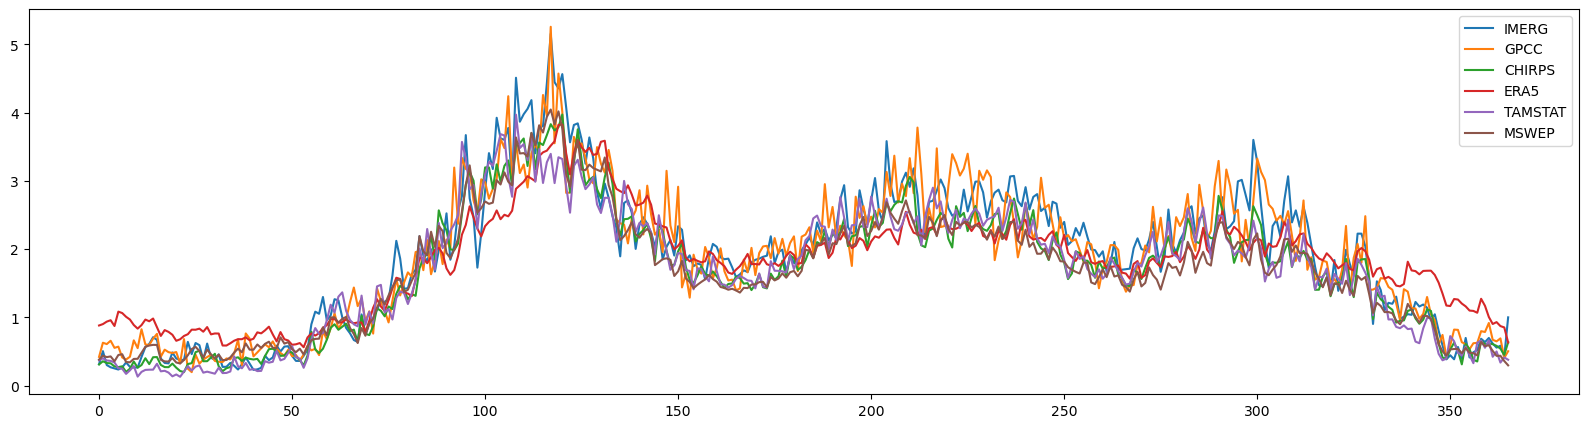

In [51]:
final_df.plot(figsize=(20,5))

<AxesSubplot:>

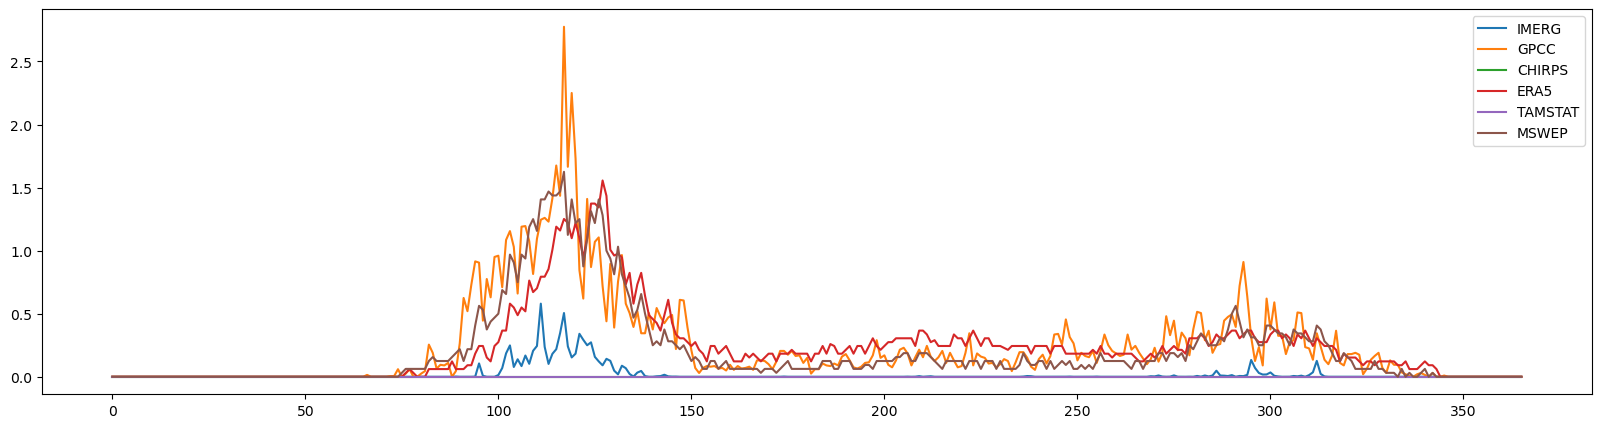

In [47]:
final_df.plot(figsize=(20,5))

In [26]:
ds_new.attrs

{'CDI': 'Climate Data Interface version 1.9.10 (https://mpimet.mpg.de/cdi)',
 'source': 'ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CHIRPS-2.0',
 'Conventions': 'CF-1.5',
 'GDAL': 'GDAL 2.0.2, released 2016/01/26',
 'title': 'CHIRPS-2.0 merged satellite / rain gauge precipitation estimate',
 'geospatial_lat_min': -40.005,
 'geospatial_lat_max': 40.005,
 'geospatial_lat_units': 'degrees_north',
 'geospatial_lon_min': -20.005,
 'geospatial_lon_max': 55.005,
 'geospatial_lon_units': 'degrees_east',
 'geospatial_lat_resolution': 0.25,
 'geospatial_lon_resolution': 0.25,
 'climexp_url': 'https://climexp.knmi.nl/select.cgi?chirps_20_25',
 'history': 'Fri Jun 18 07:50:10 2021: cdo -O -splityear /data/public/cdsdata/observations2/tmp/tmp2mopscww.nc /data/public/cdsdata/observations2/CHIRPS_total_precipitation_day_0.25x0.25_africa_\nFri Jun 18 07:50:10 2021: cdo -O -splityear /data/public/cdsdata/observations2/tmp/tmp2mopscww.nc /data/public/cdsdata/observations2/CHIRPS_total_precipita

In [25]:
precp_ds.attrs

{'Conventions': 'CF-1.6',
 'title': 'CHIRPS Version 2.0',
 'history': 'created by Climate Hazards Group',
 'version': 'Version 2.0',
 'date_created': '2015-11-20',
 'creator_name': 'Pete Peterson',
 'creator_email': 'pete@geog.ucsb.edu',
 'institution': 'Climate Hazards Group.  University of California at Santa Barbara',
 'documentation': 'http://pubs.usgs.gov/ds/832/',
 'reference': 'Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros, D.H., Verdin, J.P., Rowland, J.D., Romero, B.E., Husak, G.J., Michaelsen, J.C., and Verdin, A.P., 2014, A quasi-global precipitation time series for drought monitoring: U.S. Geological Survey Data Series 832, 4 p., http://dx.doi.org/110.3133/ds832. ',
 'comments': ' time variable denotes the first day of the given day.',
 'acknowledgements': 'The Climate Hazards Group InfraRed Precipitation with Stations development process was carried out through U.S. Geological Survey (USGS) cooperative agreement #G09AC000001 "Monitoring and Forecasting Climate, Wat

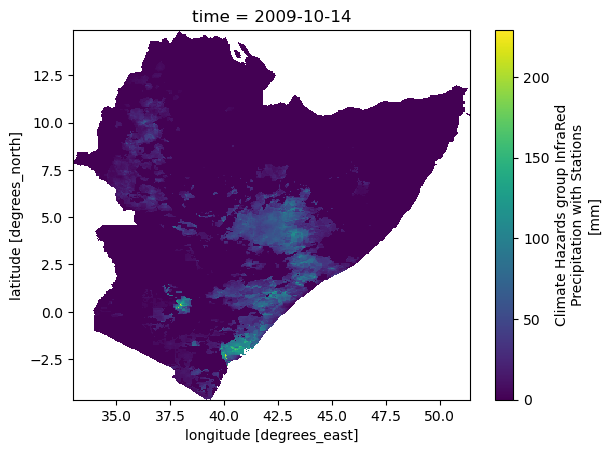

In [23]:
precp_ds.sel(time=f"14-10-{year}")["precip"].plot()

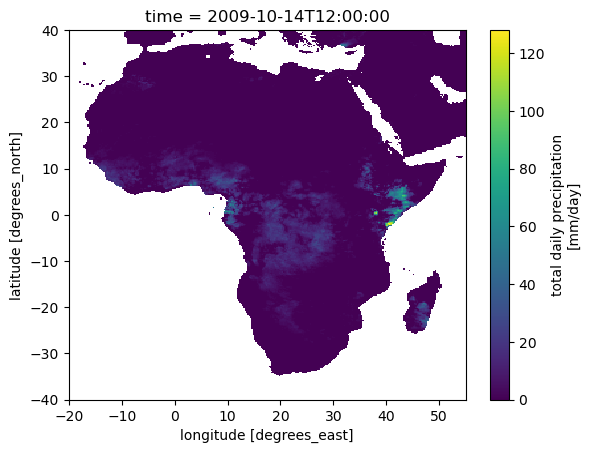

In [18]:
ds_new["pr"].sel(time=f"14-10-{year}").plot()

days are 366
Calculating the full year for boxplot
The days are 366
days are 365
For year 2009 obtaining only months 9 to 12 for boxplot
days are 365
For year 2010 obtaining only months 1 to 5 for boxplot


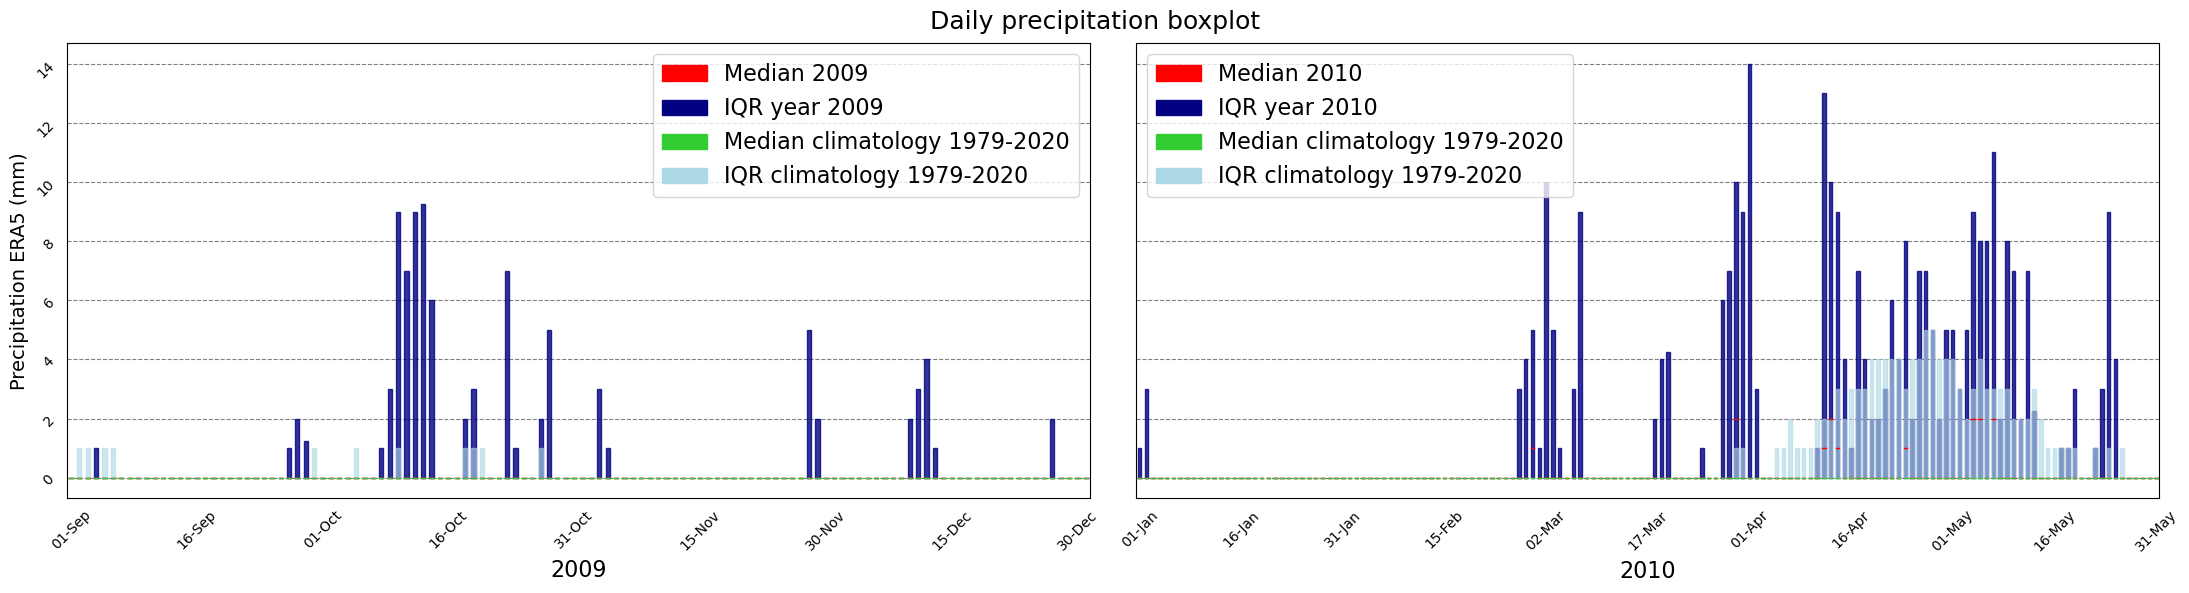

In [56]:
from p_drought_indices.analysis.visualizations.viz_vci_spi import plot_precp_2009_event,plot_veg_2009_event, plot_spi_2009_event

plot_precp_2009_event(ds_new, variable="pr")

In [30]:
path_05= "/media/BIFROST/N2/Riccardo/CHIRPS/daily/CHIRPS/CHIRPS_05/processed"

In [33]:
year = 2009

file = [f for f in os.listdir(path_05) if str(year) in f][0]

ds_other = xr.open_dataset(os.path.join(path_05, file))

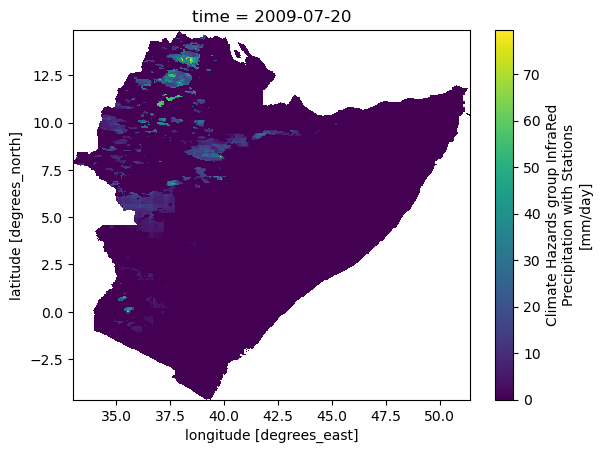

In [44]:
ds_other["precip"].isel(time=200).plot()